# Forecast Maximum Rainfall 

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import datetime
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


In [3]:
date_series = [0] * len(rainfall_df)

for index, row in rainfall_df.iterrows():
    date_series[index] = datetime.date(int(row['YEAR']), int(row['MN']), int(row['DT']))

### Plot Entire Data

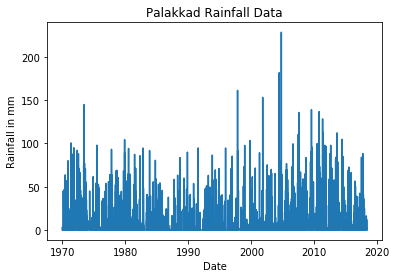

In [4]:
plt.plot(date_series, rainfall_df['..R/F'].to_numpy())
plt.title('Palakkad Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall in mm')
plt.show()

## Computing Monthly Max Rainfall

In [5]:
print(rainfall_df['..R/F'].to_numpy()[16001])

30.1


Data Type: float64, Data Shape: (580,)

First 10 data points:
[3.2, 45.0, 0.0, 47.0, 25.2, 63.6, 39.0, 57.0, 27.0, 30.0]

Last 10 data points:
[58.0, 54.2, 88.2, 41.1, 15.2, 24.8, 0.0, 12.6, 14.8, 16.2]


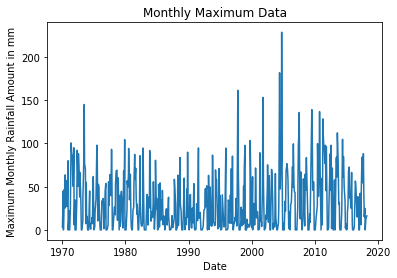

In [6]:
month_max_series = [rainfall_df.iloc[0]['..R/F']]
month_date_series = [date_series[0]]

prev_month = rainfall_df.iloc[0]['MN']

for index, row in rainfall_df.iloc[1:].iterrows():
    
    if row['MN'] == prev_month:
        if month_max_series[-1] < row['..R/F']:
            month_max_series[-1] = row['..R/F']
            month_date_series[-1] = date_series[index]
        
    else:
        month_max_series.append(row['..R/F'])
        month_date_series.append(date_series[index])
        
    prev_month = row['MN']
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_date_series, month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Date')
plt.ylabel('Maximum Monthly Rainfall Amount in mm')
plt.show()

In [7]:
train_frac = 0.85
n = month_max_series.shape[0]
num_train = int(n * train_frac)

print(f'Train Size: {num_train}, Test Size: {n - num_train}')

Train Size: 493, Test Size: 87


## Decompose the time series into trend, seasonality and remainder components

In [8]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

In [9]:
trend_series_train = trend_series[:num_train]
seasonality_series_train = seasonality_series[:num_train]
remainder_series_train = remainder_series[:num_train]

### Plot Time Series Components

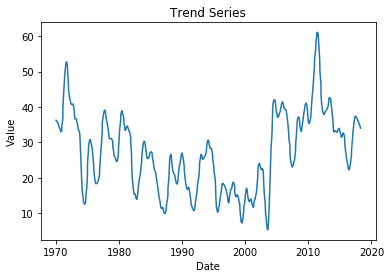

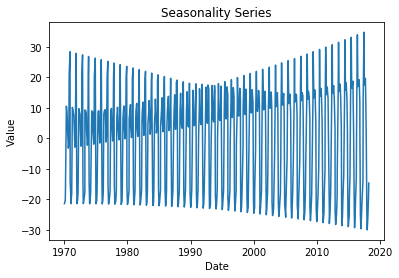

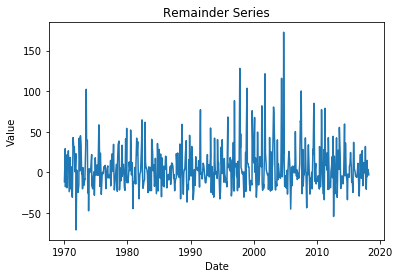

In [10]:
plt.plot(month_date_series, trend_series)
plt.title('Trend Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, seasonality_series)
plt.title('Seasonality Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, remainder_series)
plt.title('Remainder Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### Compare the inferred seasonality with actual data

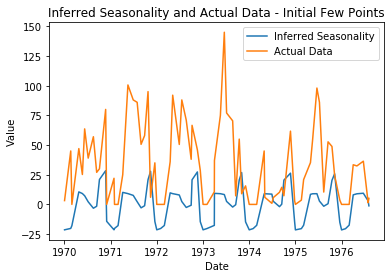

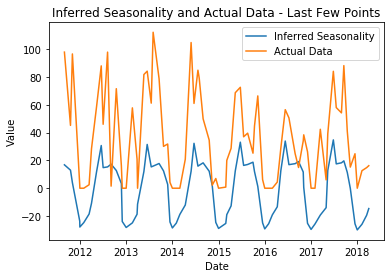

In [11]:
# Front Few Points
num_initial_points = 80

plt.plot(
    month_date_series[:num_initial_points],
    seasonality_series[:num_initial_points], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[:num_initial_points],
    month_max_series[:num_initial_points], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(
    month_date_series[-num_last_points:],
    seasonality_series[-num_last_points:], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[-num_last_points:],
    month_max_series[-num_last_points:], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.show()

## Parameter Estimation of GEV fitted to Remainder Series

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: -0.024962041792057608 
Location Parameter: -6.232810735650415 
Scale Parameter: 20.65559556724316 
Log Likelihood: -2256.204376911155


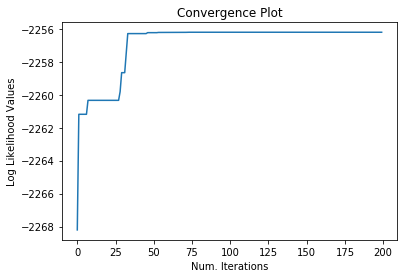

In [12]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series[:num_train],
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [13]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

### Plot PDF and CDF

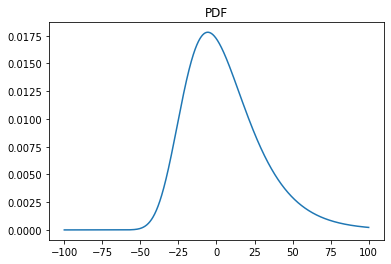

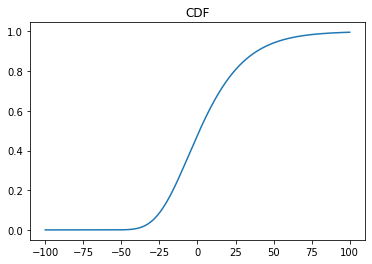

In [14]:
x = np.linspace(-100, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

## Compute CDF of each data point in remainder series

Data Type: float64, Data Shape: (580, 1)

First 5 data points:
array([[0.27312969],
       [0.84089802],
       [0.17425698],
       [0.49491452],
       [0.15739352]])

Last 5 data points:
array([[0.69752011],
       [0.38260962],
       [0.53767409],
       [0.47359551],
       [0.42212041]])


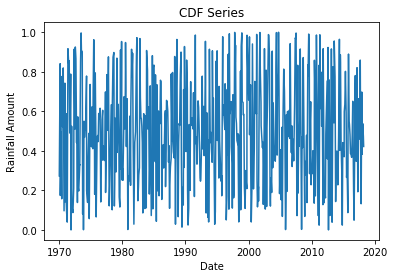

In [15]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(month_date_series, remainder_series_cdf)
plt.title('CDF Series')
plt.xlabel('Date')
plt.ylabel('Rainfall Amount')
plt.show()

## Model for Forecasting next day CDF

### Model Architecture

In [16]:
lag = 50

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [17]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (443, 50)
Output Data Shape: (443, 1)


Epoch 1/100
14/14 [==============================] - 0s 933us/step - loss: 0.0702
Epoch 2/100
14/14 [==============================] - 0s 992us/step - loss: 0.0690
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0623
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0642
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0608
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0627
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0570
Epoch 11/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0583
Epoch 12/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 13/100
14/14 [=============

14/14 [==============================] - 0s 773us/step - loss: 0.0145


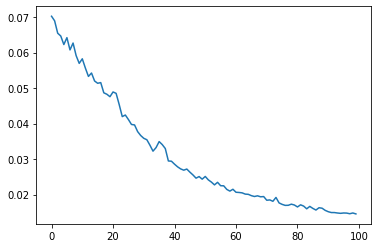

In [18]:
history = model.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

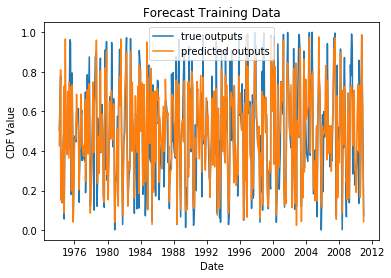

In [19]:
remainder_train_cdf = model.predict(input_data)
remainder_train = gev_dist.computeQuantile(remainder_train_cdf)

plt.plot(
    month_date_series[lag: num_train], 
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Value')
plt.legend()
plt.title('Forecast Training Data')
plt.show()

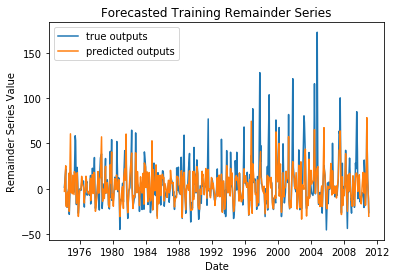

In [20]:
plt.plot(
    month_date_series[lag: num_train],
    remainder_series[lag: num_train],
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Training Remainder Series')
plt.show()

### Forecast test data

In [21]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (87, 50)
Test Output Data Shape: (87, 1)


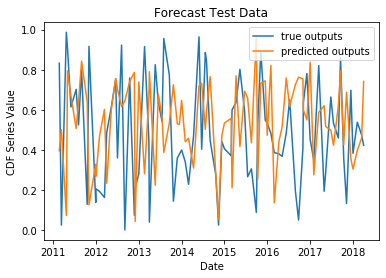

In [22]:
remainder_test_cdf = model.predict(test_input)
remainder_test = gev_dist.computeQuantile(remainder_test_cdf)

plt.plot(
    month_date_series[num_train:],
    test_output, 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Series Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

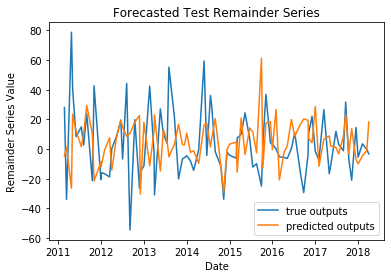

In [23]:
plt.plot(
    month_date_series[num_train:],
    remainder_series[num_train:], 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Test Remainder Series')
plt.show()

## Forecasting Trend

### Model Architecture

In [24]:
lag = 50

model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [25]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(trend_series[i - lag:i], axis=1))
    output_data.append(trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (443, 50)
Output Data Shape: (443, 1)


Epoch 1/100
14/14 [==============================] - 0s 772us/step - loss: 117.0508
Epoch 2/100
14/14 [==============================] - 0s 778us/step - loss: 44.7456
Epoch 3/100
14/14 [==============================] - 0s 811us/step - loss: 31.9438
Epoch 4/100
14/14 [==============================] - 0s 806us/step - loss: 21.6471
Epoch 5/100
14/14 [==============================] - 0s 778us/step - loss: 13.7552
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 13.1658
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 11.3419
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 10.7535
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 8.3572
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss: 7.1911
Epoch 11/100
14/14 [==============================] - 0s 1ms/step - loss: 4.2801
Epoch 12/100
14/14 [==============================] - 0s 1ms/step - loss: 3.8826
Epoch 13/100
14/14

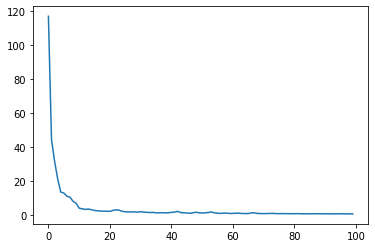

In [26]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

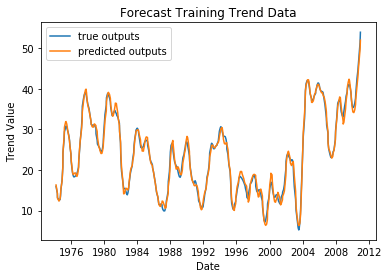

In [27]:
trend_train = model_trend.predict(input_data)

plt.plot(
    month_date_series[lag: num_train],
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train],
    trend_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Training Trend Data')
plt.show()

### Forecast test data

In [28]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (87, 50)
Test Output Data Shape: (87, 1)


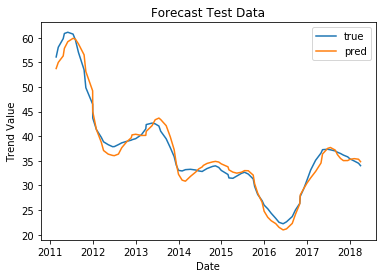

In [29]:
trend_test = model_trend.predict(test_input)

plt.plot(
    month_date_series[num_train:], 
    test_output, 
    label='true'
)
plt.plot(
    month_date_series[num_train:], 
    trend_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecasting Seasonality

### Forecast training data

In [30]:
seasonality_train = seasonality_series[:num_train][lag:]

### Forecast test data

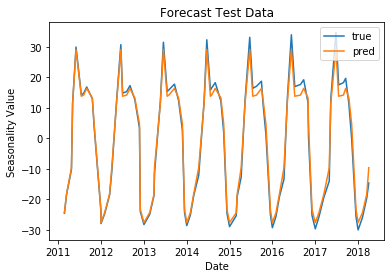

In [31]:
season_values = seasonality_series[:num_train][-12:]
seasonality_test = np.zeros((n - num_train, 1))

for i in range(n - num_train):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(
    month_date_series[num_train:],
    seasonality_series[num_train:], 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    seasonality_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Seasonality Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecast Maximum Rainfall

In [32]:
print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

(443, 1) (443, 1) (443, 1)
(87, 1) (87, 1) (87, 1)


### Forecast training data

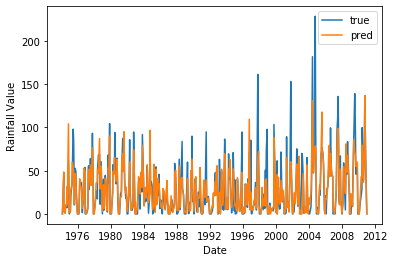

In [33]:
pred_train = np.maximum(remainder_train + trend_train + seasonality_train, 0)
true_train = month_max_series[:num_train][lag:]

plt.plot(
    month_date_series[lag: num_train],
    true_train, 
    label='true'
)
plt.plot(
    month_date_series[lag: num_train],
    pred_train, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()

### Forecast test data

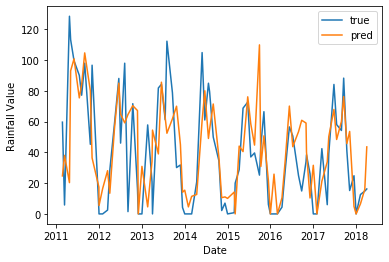

In [34]:
pred_test = np.maximum(remainder_test + trend_test + seasonality_test, 0)
true_test = month_max_series[num_train:]

plt.plot(
    month_date_series[num_train:],
    true_test, 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    pred_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()